In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import pandas as pd
from scipy import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import math
import random
import argparse
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

In [ ]:
df = pd.read_csv('all_keywords300.csv')
total_documents = df['Keywords'][1:].tolist()



def add_to_doc_matrix(word, doc_num, count_docs):
    if word not in term_doc_matrix.keys():
        term_doc_matrix[word] = [0 for j in range(count_docs)]
    term_doc_matrix[word][doc_num] += 1


def get_doc_vector(tokenized_doc, dtm_key_list):
    dtm_len = len(dtm_key_list)
    vector = [0 for j in range(dtm_len)]
    for i in range(dtm_len):
        vector[i] += tokenized_doc.count(dtm_key_list[i])
    return vector

term_doc_matrix = {}

for i in range(len(total_documents)):
    doc = total_documents[i].split(',')
    for token in doc:
        add_to_doc_matrix(token, i, 300)

dtm = pd.DataFrame.from_dict(term_doc_matrix)
dtm = dtm.to_numpy()


In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
print(dtm)

[[2 2 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 1 2 3]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
pca = PCA(n_components=2)
dtm_pca = pca.fit_transform(dtm)

**K-MEANS WITH K = 8**



In [ ]:
def init_random_centroids(X, K):
    centroids = X[(np.random.choice(X.shape[0], K)), :]
    return centroids

In [ ]:
def find_closest_centroid(X, centroids):
    idx = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        idx[i] = np.argmin(np.sqrt(np.sum((X[i,:]-centroids)**2, axis=1)))+1
    return idx

In [ ]:
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[(idx==i+1).T[0], :], axis=0)
    return centroids

In [ ]:
def plot_kmeans(X, centroids, previous, idx, K, axes):
    for i, ax in enumerate(axes):
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=idx.ravel(), legend=False, palette=['r', 'g', 'b','k','y','c','m','w'], ax=ax)
        if i==0:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        else:
            sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='X', color='k', legend=False, s=100, ax=ax)
        for i in range(centroids.shape[0]):
            ax.plot([centroids[i,0], previous[i,0]], [centroids[i,1], previous[i,1]], '--k');

In [ ]:
def kmeans(X, initial_centroids, max_iters, plot_progress):
    if plot_progress:
        ncols = 3
        nrows = int(max_iters/ncols)
        if max_iters % ncols > 0:
            nrows = nrows + 1
        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,nrows*8))
        ax_tuple = list(np.ndindex(nrows,ncols))
        for ax in ax_tuple[max_iters:]:
            axes[ax].set_axis_off()
        ax_tuple = ax_tuple[:max_iters]

    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids

    for i in range(max_iters):
        idx = find_closest_centroid(X, centroids)

        if plot_progress:
            plot_axes = [axes[axi] for axi in ax_tuple[i:]]
            axes[ax_tuple[i]].set_title('K-Means iteration {0}/{1}'.format(i+1, max_iters))
            plot_kmeans(X, centroids, previous_centroids, idx, K, plot_axes)
            previous_centroids = centroids
            previous_ax = plt.gca()
        else:
            print('K-Means iteration {0}/{1}'.format(i+1, max_iters))
        centroids = compute_centroids(X, idx, K)

    if plot_progress:
        plt.show()
    return centroids, idx

In [ ]:
def compute_euclidean_distance(point1, point2):
    # Calculate the Euclidean distance between two points
    return np.sqrt(np.sum((point2 - point1) ** 2))


def compute_sse(X, centroids, idx):
    m = X.shape[0]
    K = centroids.shape[0]
    sse = 0
    for i in range(m):
        centroid_idx = int(idx[i][0])
        #print(centroid_idx)
        centroid = centroids[centroid_idx - 1]
        sse += np.sum((X[i] - centroid) ** 2)
    return sse


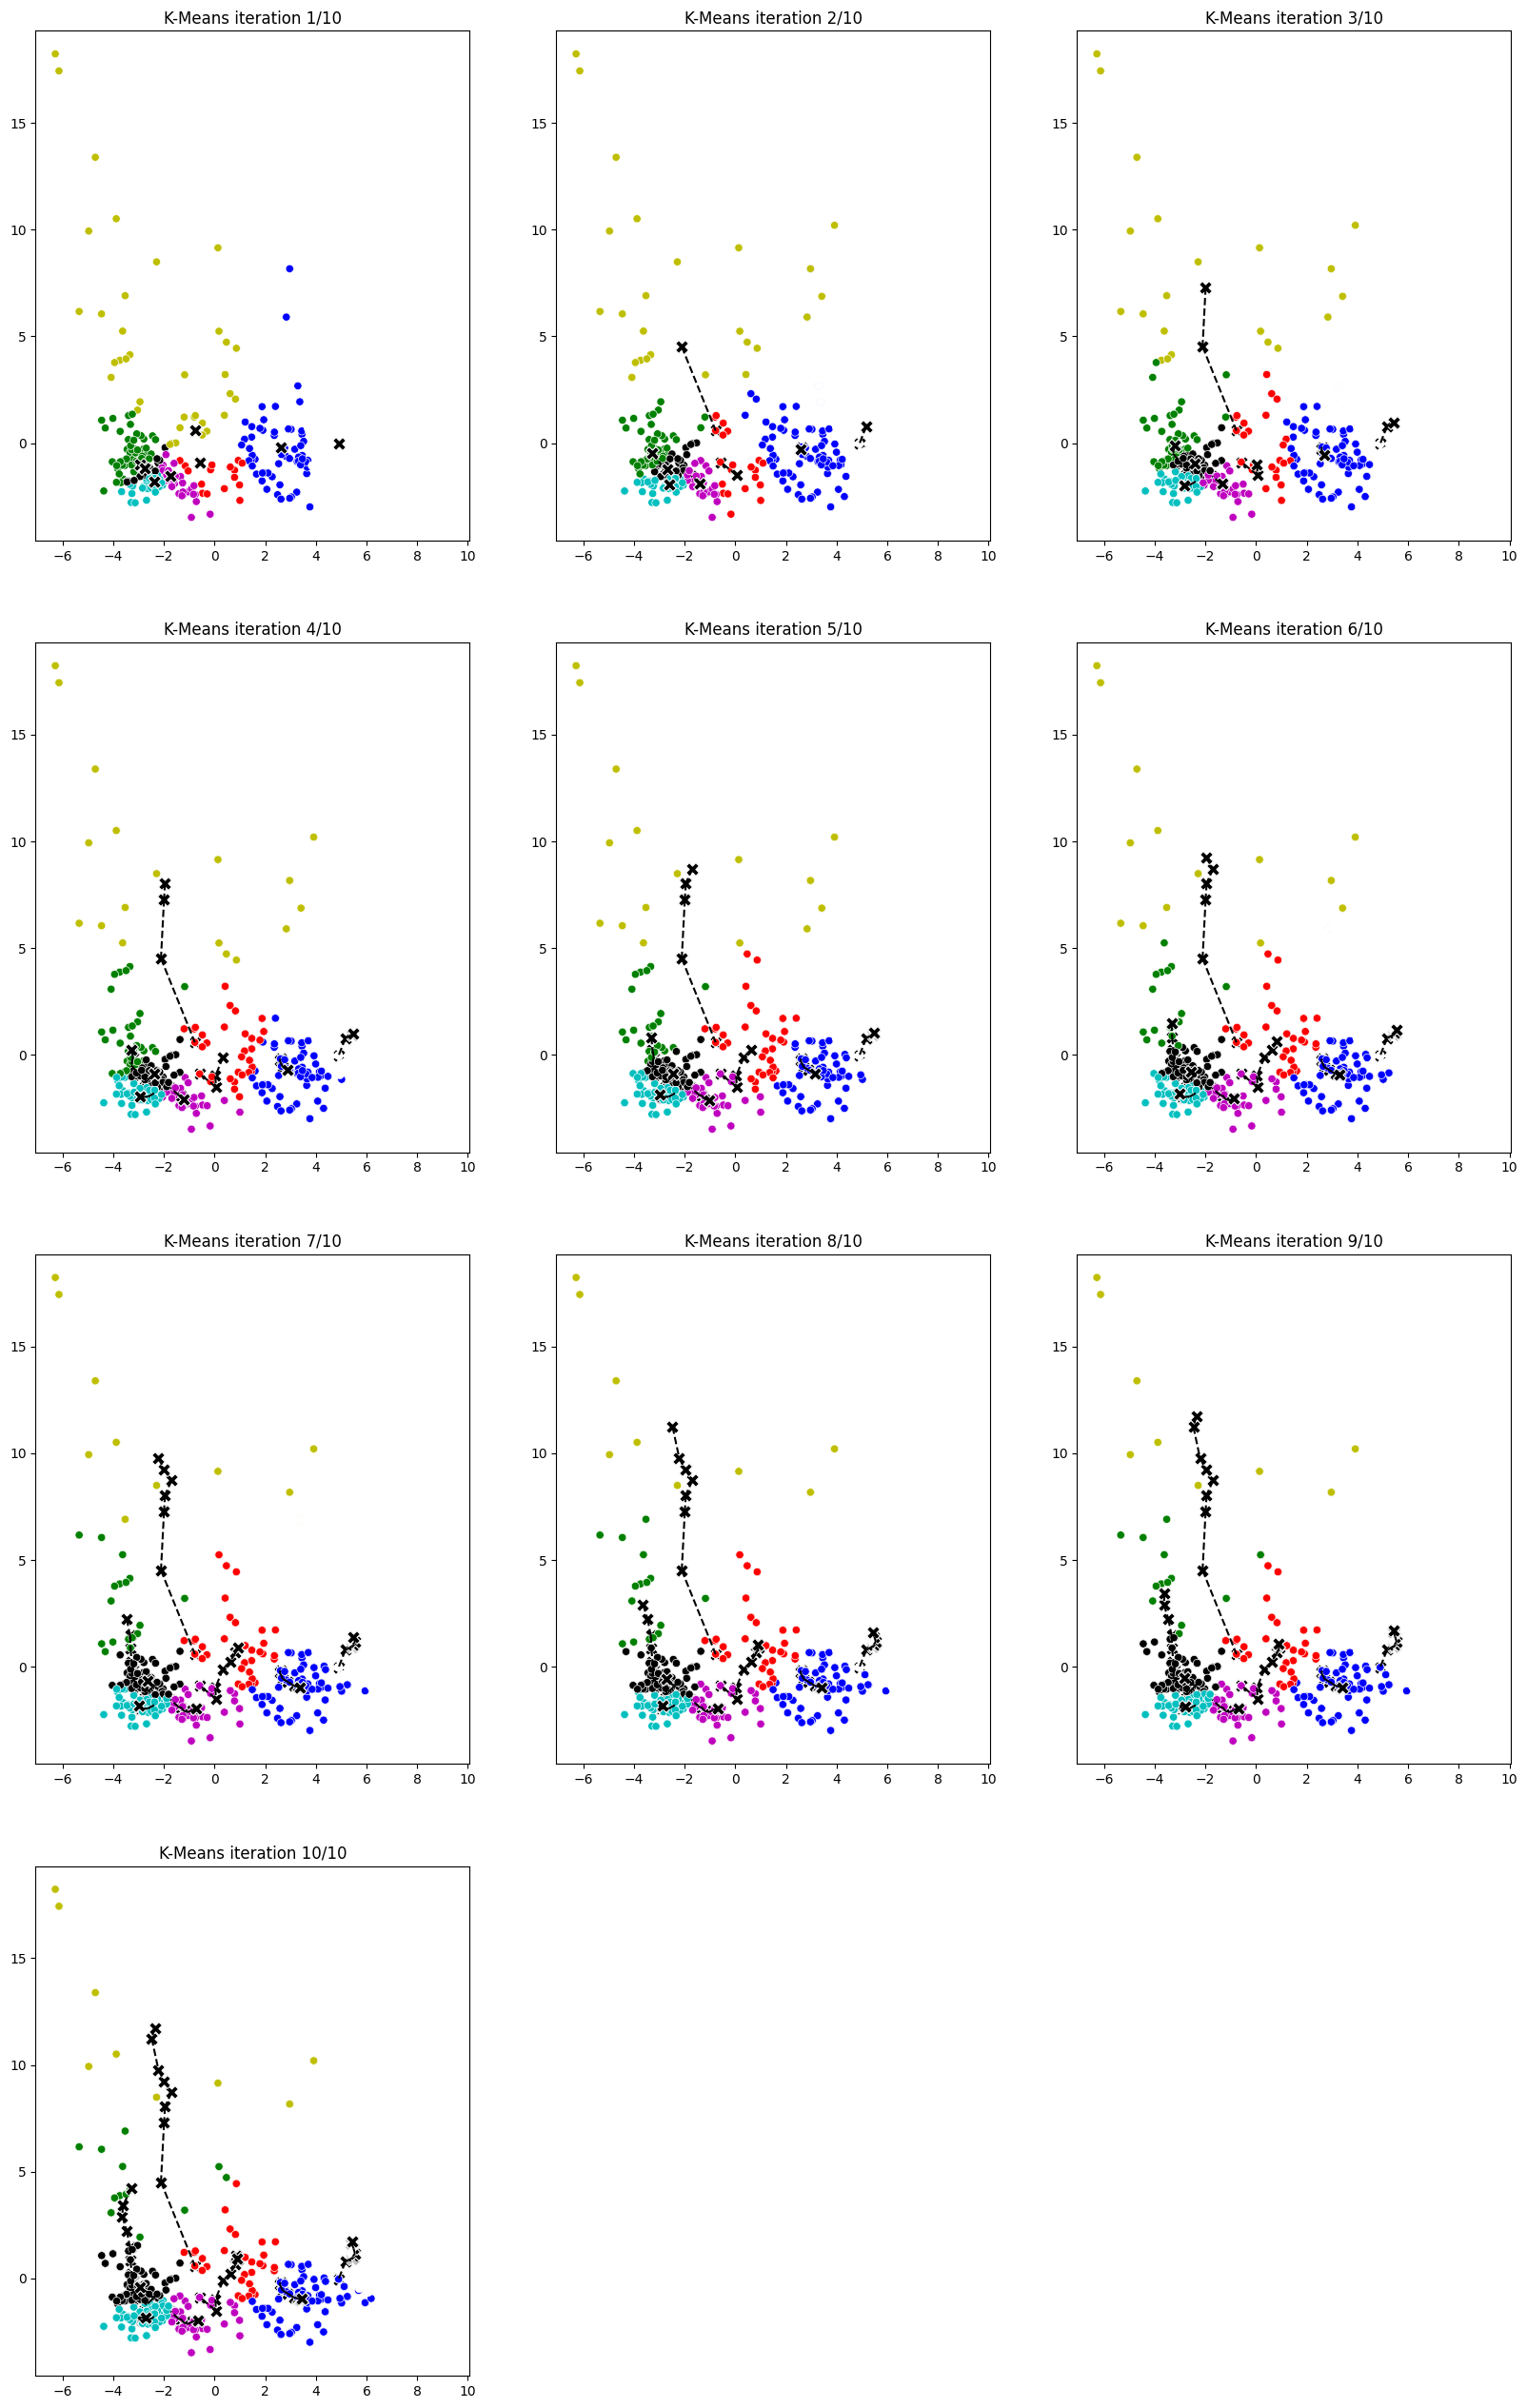

In [ ]:
K = 8
max_iters = 10
initial_centroids = init_random_centroids(dtm_pca, K)
centroids, idx = kmeans(dtm_pca, initial_centroids, max_iters, True)

In [ ]:
sse = compute_sse(dtm_pca, centroids, idx)
print("Sum of Squared Errors K-means:", sse)

Sum of Squared Errors K-means: 868.0924839547672


**DBSCAN**

In [ ]:
X_principal = pd.DataFrame(dtm_pca)
X_principal.columns = ['P1', 'P2']
print(X_principal.head())

db_default = DBSCAN(eps=0.75, min_samples=10).fit(X_principal)
labels = db_default.labels_

         P1        P2
0 -3.393117  1.287766
1  2.277295 -1.576460
2 -1.792954 -1.569588
3 -3.368882 -0.992221
4 -2.253182 -1.650870


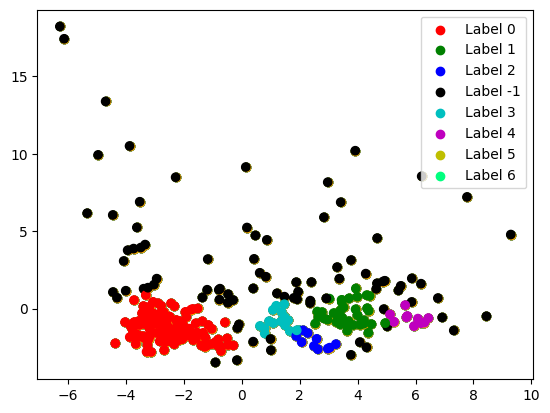

In [ ]:
colours = {}
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
colours[3] = 'c'
colours[4] = 'm'
colours[5] = 'y'
colours[6] = 'springgreen'
colours[7] = 'orange' # for hierarchical

# Building the colour vector for each data point
cvec = [colours[label] for label in labels]

# For the construction of the legend of the plot
r = plt.scatter(X_principal['P1'], X_principal['P2'], color='r');
g = plt.scatter(X_principal['P1'], X_principal['P2'], color='g');
b = plt.scatter(X_principal['P1'], X_principal['P2'], color='b');
k = plt.scatter(X_principal['P1'], X_principal['P2'], color='k');
c = plt.scatter(X_principal['P1'], X_principal['P2'], color='c');
m = plt.scatter(X_principal['P1'], X_principal['P2'], color='m');
y = plt.scatter(X_principal['P1'], X_principal['P2'], color='y');
sg = plt.scatter(X_principal['P1'], X_principal['P2'], color='springgreen')
og = plt.scatter(X_principal['P1'], X_principal['P2'], color='orange')

# Plotting P1 on the X-Axis and P2 on the Y-Axis
# according to the colour vector defined

plt.scatter(X_principal['P1'], X_principal['P2'], c=cvec)

# Building the legend
plt.legend((r, g, b, k, c, m, y, sg),
           ('Label 0', 'Label 1', 'Label 2', 'Label -1', 'Label 3', 'Label 4', 'Label 5', 'Label 6'))

plt.show()

In [ ]:
# find centroids
def create_centroids(labels):
    centroids_arr = []
    for i in range(-1, max(labels) + 1):
        sum_x = 0
        sum_y = 0
        cnt_points = 0
        for j in range(len(labels)):
            if labels[j] == i:
                sum_x += dtm_pca[j][0]
                sum_y += dtm_pca[j][1]
                cnt_points += 1
        centroids_arr.append([sum_x / cnt_points, sum_y / cnt_points])
    return centroids_arr

In [ ]:
def compute_sse_dbscan(X, centroids, idx):
    m = X.shape[0]
    K = centroids.shape[0]
    sse = 0
    for i in range(m):
        centroid_idx = idx[i] + 1
        # print(centroid_idx)
        centroid = centroids[centroid_idx]
        sse += np.sum((X[i] - centroid) ** 2)
    return sse

In [ ]:
centroids_dbscan = create_centroids(labels)
print("Dbscan (SSE): ", compute_sse_dbscan(dtm_pca, np.array(centroids_dbscan), labels))

Dbscan (SSE):  2896.6578033624555


**Hierarchical**

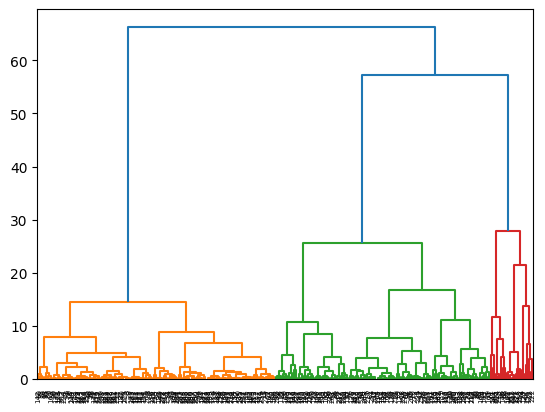

In [ ]:
linkage_data = linkage(dtm_pca, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

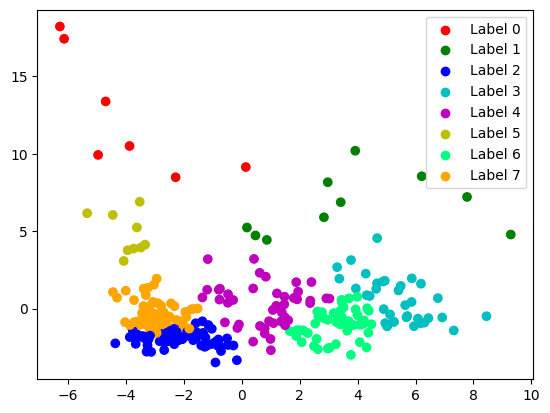

In [ ]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=8, linkage='ward')
labels_hierarchical = hierarchical_cluster.fit_predict(dtm_pca)

color_vec = [colours[label] for label in labels_hierarchical]

plt.legend((r, g, b, c, m, y, sg, og),
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7'))
plt.scatter(dtm_pca[:, 0], dtm_pca[:, 1], c=color_vec)
plt.show()

In [ ]:
def create_centroids_hierarchical(labels):
    centroids_arr = []
    for i in range(max(labels) + 1):
        sum_x = 0
        sum_y = 0
        cnt_points = 0
        for j in range(len(labels)):
            if labels[j] == i:
                sum_x += dtm_pca[j][0]
                sum_y += dtm_pca[j][1]
                cnt_points += 1
        centroids_arr.append([sum_x / cnt_points, sum_y / cnt_points])
    return centroids_arr

def compute_sse_hierarchical(X, centroids, idx):
    m = X.shape[0]
    K = centroids.shape[0]
    sse = 0
    for i in range(m):
        centroid_idx = idx[i]
        # print(centroid_idx)
        centroid = centroids[centroid_idx]
        sse += np.sum((X[i] - centroid) ** 2)
    return sse

In [ ]:
centroids_hierarchical = create_centroids_hierarchical(labels_hierarchical)
print("Hierarchical (SSE): ", compute_sse_hierarchical(dtm_pca, np.array(centroids_hierarchical), labels_hierarchical))

Hierarchical (SSE):  731.2504567224836



**تحلیل موضوعات کلاستر های سلسله مراتبی**

 لیبل 0: نویز

 لیبل 1: خودکارآمدی

 لیبل 2: تاثیر سلامت روان بر جسم

 لیبل 3: نقش کودکی در روان درمانی

 لیبل 4: تاثیرات خانواده و مدرسه بر کودکان و نوجوانان


 لیبل 5: زندگی زناشویی

 لیبل 6: هیجان و اضطراب

 لیبل 7: تربیت و آموزش